In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [3]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob

In [4]:
def get_posterior(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)
def get_posteriors(d, y):
    d = augment_d(d)
    var_y = noise * np.eye(y.shape[1])
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y.T
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)

In [16]:
#d0 = np.random.randn(20,2)
d0 = np.array([[0,0] for i in range(10)])
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([100,100, 0])
noise = 1

In [6]:
theta = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T)
theta2 = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T)

z = np.random.randn(d0.shape[0]) * noise
z2 = np.random.randn(d0.shape[0]) * noise
print(get_posterior(d0, theta @ augment_d(d0).T + z))
print(get_posteriors(np.array(d0), np.array([theta @ augment_d(d0).T + z, theta2 @ augment_d(d0).T + z2])))

(array([0.        , 0.        , 1.30381425]), array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.21857101]]))
(array([[0.        , 0.        ],
       [0.        , 0.        ],
       [1.24475156, 0.40156995]]), array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.30151134]]))


In [7]:
def MI(d, N=50):
    thetas = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=N)
    z = np.random.randn(N, d.shape[0]) * noise
    y = thetas @ augment_d(d).T + z
    mean, A = get_posteriors(d, y)
    #print(mean.T)
    results = [stable_multivariate_gaussian_logpdf(theta_i, mean_i, A @ A.T) for theta_i, mean_i in zip(thetas, mean.T)]
    return 1/N * np.sum(results) - 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * (A_prior @ A_prior.T)))

In [8]:
cov_prior = A_prior @ A_prior.T
def mutual_information(d):
    N = 10 # amount of theta samples
    M = 5 # amount of z samples
    thetas = np.random.multivariate_normal(mean_prior, cov_prior, N)
    results = []
    for theta in thetas:
        zs = np.random.randn(M)
        ys = np.array([augment_d(d) @ theta + noise * z for theta in thetas for z in zs])
        for y in ys:
            mean, A = get_posterior(d, y)
            log_posterior = stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T) # using posterior_distribution from last week
            log_prior = stable_multivariate_gaussian_logpdf(theta, mean_prior, cov_prior)
            results.append(log_posterior - log_prior)
    return 1/(N * M) * np.sum(results)

In [9]:
def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def KLD_opt(mean_q, A_q, mean_p, A_p):
    # Compute Cholesky decomposition
    L_p = np.linalg.cholesky(A_p @ A_p.T)
    L_q = np.linalg.cholesky(A_q @ A_q.T)

    # Compute trace term
    trace_term = np.sum(np.log(np.diag(L_p))) - np.sum(np.log(np.diag(L_q)))

    # Compute mean difference term
    mean_diff = mean_p - mean_q
    mean_diff_term = np.dot(np.linalg.solve(L_p.T, np.linalg.solve(L_p, mean_diff)), mean_diff)

    # Compute bar_sigma_p and bar_sigma_q
    bar_sigma_q = np.linalg.norm(L_q)
    bar_sigma_p = np.linalg.norm(L_p)

    k = len(mean_q)

    return 0.5 * (trace_term + mean_diff_term - k + np.log(bar_sigma_p / bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def log_likelihood(y, theta, d):
    #print(np.array([np.eye(len(d)) for _ in theta.T]).shape)
    d_offset = np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
    #print(np.mean(np.square(y - theta.T @ d.T), axis=1))
    #print(d)
    likelihood_cov = np.mean(np.square(y - theta.T @ d_offset.T), axis=1)[:, np.newaxis, np.newaxis] * np.array([np.eye(len(d)) for _ in theta.T])
    #print(likelihood_cov)
    likelihood_mean = theta.T @ d_offset.T
    return [stable_multivariate_gaussian_logpdf(y, mean, cov) for mean, cov in zip(likelihood_mean, likelihood_cov)]
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 500):
    #print("Computing elbo for ", q_params, d, y_i)
    mean, A = q_params
    #values = np.random.multivariate_normal(np.zeros(shape), np.eye(shape), size=batch_size)
    #theta = mean + A @ values.T
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = log_likelihood_opt(y_i, theta, d)
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    #print(lik[0])
    
    return mean_term - kld_term

In [10]:
def log_posterior(theta_i, q_params):
    mean, A = q_params
    return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)
def log_posterior_grad(theta_i, y_i, d, q_params):
    batch_size=500
    
    def training_hessian_inner(q_params):
        return elbo_optimized(decode_q_params(q_params), d, y_i, batch_size=batch_size)
    
    def training_mixed_partials_inner(encoded_q):
        def deep_inner(d):
            return elbo_optimized(
                    decode_q_params(encoded_q), 
                    decode_d(d), 
                    y_i, 
                    batch_size=batch_size
                )
        #print("Encoded d %s" % str(encode_d(d)))
        #print("inner result: %s" % str(encode_d(grad(lambda d: elbo(decode_q_params(encoded_q), d, y_i))(d))))
        def decode_d_y(d_y):
            size = d.shape[0] * d.shape[1]
            return decode_d(d_y[0:size]), d_y[size:]
        def encode_d_y(d, y):
            return np.concatenate((encode_d(d), y_i))
        return encode_d(
            grad(
                deep_inner
            )(encode_d(d))
        )
    def training_mixed_partials_inner_2(encoded_d):
        d = decode_d(encoded_d)
        def deep_inner(encoded_q):
            mean, A = decode_q_params(encoded_q)
            return elbo_optimized((mean, A), d, y_i, batch_size=batch_size)
        return grad(
                deep_inner
            )
    
    def inner_grad_q(encoded_q_params):
        mean, A = decode_q_params(encoded_q_params)
        return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)
    
    
    training_hessian = hessian(training_hessian_inner)
    training_mixed_partials = jacobian(training_mixed_partials_inner)
    encoded_q = encode_q_params(q_params)
    latest_hessian = training_hessian(encoded_q) # 12 x 12
    grad_log_q = grad(inner_grad_q)(encoded_q).reshape(1, len(encoded_q)) # 1 x 12
    #alt_grad = -jacobian(lambda d: encode_q_params(get_posterior(decode_d(d), y_i)))(encode_d(d))
    #alt_grad = -jacobian(lambda d: encode_q_params(get_posterior(decode_d(d), y_i)))(encode_d(d))
    #return (grad_log_q @ alt_grad)[0]
    #print("Alt grad: ", alt_grad)
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            evaluated_partials = training_mixed_partials(encoded_q)
            inv = np.linalg.inv(latest_hessian)
            #print("New grad: ", (- inv @ evaluated_partials.T))
            #return (grad_log_q @ alt_grad)[0]
            return (grad_log_q @ (- inv @ evaluated_partials.T))[0]
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape[0])
    raise ValueError("Was not able to invert hessian")
def optimal_q(d, y_i, rate=0.1, decay=0.001, iters=100):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return - elbo_optimized(q_params, d, y_i)
    def callback(qi, g):
        #print("Elbo: %f.05,\t  grad: %f.05" % (timer(lambda: -objective_f(qi), label="\t ELBO"), np.linalg.norm(g)))
        return True
        #print("\t New ELBO iteration. mean=%s, A=%s" % (str(mean), str(A)))
    results = optimizer(
        encode_q_params(
            (mean_prior, A_prior)
        ), 
        grad(objective_f), 
        callback=callback, 
        label="Optimizing for q", 
        rate=rate,
        iters=iters, 
        leave=False,
        decay=decay
    )
    return decode_q_params(results)
def MI_grad(d, N=50):
    d_offset = augment_d(d)
    size = d.shape[0]
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior @ A_prior, size=N)
    sample_results = []
    #elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Sampling over theta", leave=False):
        theta_i = theta_samples[i]
        z_i = np.random.multivariate_normal(np.zeros(size), noise * np.eye(size))
        def get_y_from_d(d):
            d_offset = augment_d(d)
            return theta_i @ d_offset.T + z_i
        y_i = get_y_from_d(d)
        q_params = get_posterior(d, y_i)
        analytical_q = None
        #data_sets.append((d, y_i, q_params, analytical_q))
        #optimal_qs.append(q_params)
        def log_posterior_grad_alt(theta_i, y_i, d, q_params):
            return grad(
              lambda xs_: -log_posterior(
                  theta_i, 
                  get_posterior(decode_d(xs_), y_i)
                  )
              )(encode_d(d))
        
        result = log_posterior_grad_alt(q_params[0], y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1)
        #print(result, log_posterior_grad_alt(theta_i, y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1))
        #result = log_posterior_grad_alt(theta_i, y_i, d, q_params) * (log_posterior(theta_i, q_params) + 1)
        #print("Got result!")
        sample_results.append(result)
        #elbos.append(elbo(q_params, d, y_i))
    #optimal_params.append(optimal_qs)
    #print("ELBO: ", str(np.mean(elbos)))
    #print("MI_grad: ", str(np.mean(sample_results)))
    #print(sample_results)
    #print("sample results, mean 0", str(np.mean(np.array(sample_results), axis=0).shape))
    #print(encode_d(decode_d(np.mean(np.array(sample_results), axis=0), dim=3)[:, 0:2]))
    return decode_d(np.mean(np.array(sample_results), axis=0), dim=2)

In [11]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        #if i > 0 and np.linalg.norm(g) < thres or np.linalg.norm(g) > 10:
        #    break
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [17]:
dis = []
mis = []
def callback(di, g):
    dis.append(decode_d(di))
    return True
def g(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    return -encode_d(g_)
dis.append(d0)
mis.append(MI(d0, N=30))
optimizer(encode_d(d0), grad(g), rate=1, decay=0.0001, iters=100000, callback=callback)
dis = np.array(dis)

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
mis

ValueError: setting an array element with a sequence.

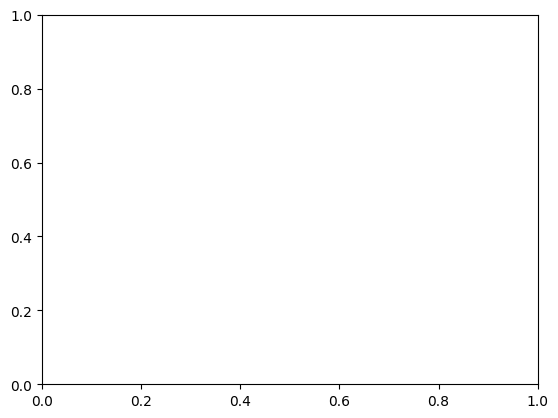

In [14]:
plt.plot(np.arange(0, len(mis)), mis)
#plt.yscale('log')
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")
plt.show()

In [ ]:
def analytical_mutual_information(d, dim=3): # From week 2
    covariance_prior = A_prior @ A_prior.T
    var_y = noise * np.eye(d.shape[0])
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    #val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior))
plt.plot(np.arange(0, len(dis)), np.array([MI(d, N=10) for d in dis]))
#plt.yscale('log')
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

Text(0, 0.5, 'Norm of d')

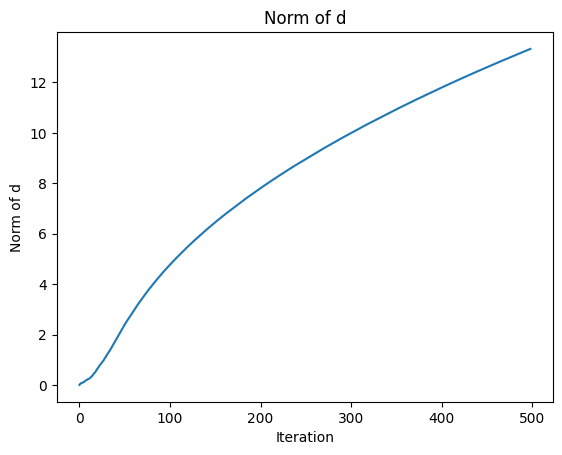

In [13]:
plt.plot(np.arange(0, len(dis)), np.array([np.linalg.norm(d) for d in dis]))
#plt.yscale('log')
plt.title("Norm of d")
plt.xlabel("Iteration")
plt.ylabel("Norm of d")

In [ ]:
MI_grad(dis[5])

In [ ]:
i = 0
di = dis[i]
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.scatter(di[:, 0], di[:, 1])
plt.title("$d$ at iteration %d" % (i + 1))

Text(0.5, 1.0, 'Points move per iteration (blue is start, orange is end)')

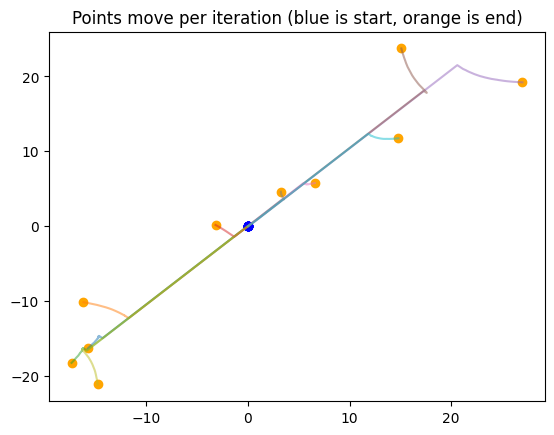

In [18]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.5)
plt.title("Points move per iteration (blue is start, orange is end)")

In [ ]:
from sklearn import feature_selection


In [ ]:
feature_selection.mutual_info_regression(d0, augment_d(d0) @ mean_prior)

In [ ]:
d0